In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import re
import json
import unicodedata
import pandas as pd
from pathlib import Path
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("../../src")
from verbatim_rag.util.text_processing_util import clean_text_df

In [35]:
DATA_DIR = Path("../../data/dev")
input_dir = DATA_DIR / "raw"
output_dir = DATA_DIR / "processed"
data_file_name = "archehr-qa.xml"
key_file_name = "archehr-qa_key.json"
mapping_file_name = "archehr-qa_mapping.json"

# Extract & Organize

**Key-File:**
- Provides sentence-level answer annotations.
- Labels answers as "essential" or "not-relevant".

Load from json file

In [36]:
key_file_path = input_dir / key_file_name
with open(key_file_path, "r") as f:
    key_data = json.load(f)

Convert to dataframe

In [37]:
structured_key_data = []

for case in key_data:
    case_id = case["case_id"]
    for answer in case["answers"]:
        structured_key_data.append({
            "case_id": case_id,
            "sentence_id": answer["sentence_id"],
            "relevance": answer["relevance"]
        })

# Create Pandas DataFrame
key_df = pd.DataFrame(structured_key_data)

In [38]:
key_df.head()

,case_id,sentence_id,relevance
0,1,0,not-relevant
1,1,1,essential
2,1,2,not-relevant
3,1,3,not-relevant
4,1,4,not-relevant


**Mapping-File:**
- Maps case IDs to specific documents from MIMIC-III.
- Shows where the context for each question is located.

Load from json file

In [39]:
mapping_file_path = input_dir / mapping_file_name
with open(mapping_file_path, "r") as f:
    mapping_data = json.load(f)

Convert to dataframe

In [40]:
structured_mapping_data = []

for case in mapping_data:
    structured_mapping_data.append({
        "case_id": case["case_id"],
        "document_id": case["document_id"],
        "document_source": case["document_source"]
    })

# Create Pandas DataFrame
mapping_df = pd.DataFrame(structured_mapping_data)

In [41]:
mapping_df.head()

,case_id,document_id,document_source
0,1,179164_41762,mimic-iii
1,2,191708_35669,mimic-iii
2,3,132786_42206,mimic-iii
3,4,180932_37135,mimic-iii
4,5,190179_39908,mimic-iii


**Train-set:**

Contains cases with unique ids.
Stores questions, associated clinical context

Load from XML file

In [42]:
def parse_xml_to_dataframe(path_to_xml):
    tree = ET.parse(path_to_xml)
    root = tree.getroot()

    structured_data = []

    for case in root.findall("case"):
        case_id = case.attrib["id"]

        # Extract patient details
        patient_narrative = case.find("patient_narrative").text if case.find("patient_narrative") is not None else "No patient narrative"
        patient_question = case.find("patient_question/phrase").text if case.find("patient_question/phrase") is not None else "No patient question"
        clinician_question = case.find("clinician_question").text if case.find("clinician_question") is not None else "No clinician question"

        # Extract clinical note excerpts
        note_excerpt = case.find("note_excerpt").text if case.find("note_excerpt") is not None else "No note excerpt"

        # Extract sentence-level details from note excerpts
        for sentence in case.findall("note_excerpt_sentences/sentence"):
            sentence_id = sentence.attrib["id"]
            paragraph_id = sentence.attrib["paragraph_id"]
            start_char_index = sentence.attrib["start_char_index"]
            length = sentence.attrib["length"]
            sentence_text = sentence.text if sentence.text is not None else "No sentence text"

            structured_data.append({
                "case_id": case_id,
                "patient_narrative": patient_narrative,
                "patient_question": patient_question,
                "clinician_question": clinician_question,
                "note_excerpt": note_excerpt,
                "sentence_id": sentence_id,
                "sentence_text": sentence_text,
                "paragraph_id": paragraph_id,
                "start_char_index": start_char_index,
                "length": length
            })

    return pd.DataFrame(structured_data)

In [43]:
data_file_path = input_dir / data_file_name
data_df = parse_xml_to_dataframe(data_file_path)

Cast attributes to int for merging

In [44]:
data_df["case_id"] = data_df["case_id"].astype(int)
data_df["sentence_id"] = data_df["sentence_id"].astype(int)
key_df["case_id"] = key_df["case_id"].astype(int)
key_df["sentence_id"] = key_df["sentence_id"].astype(int)
mapping_df["case_id"] = mapping_df["case_id"].astype(int)

Merge the dataframes into one

In [45]:
# Merge XML data with answer relevance labels
temp_df = data_df.merge(key_df, on=["case_id", "sentence_id"], how="left")

# Merge with document mapping
all_df = temp_df.merge(mapping_df, on="case_id", how="left")

In [46]:
all_df.head()

,case_id,patient_narrative,patient_question,clinician_question,note_excerpt,sentence_id,sentence_text,paragraph_id,start_char_index,length,relevance,document_id,document_source
0,1,\nI had severe abdomen pain and was hospitalis...,\nMy question is if the sludge was there does ...,\nWhy was ERCP recommended to him over continu...,\nBrief Hospital Course:\n\nDuring the ERCP a ...,0,\nBrief Hospital Course:\n,0,0,22,not-relevant,179164_41762,mimic-iii
1,1,\nI had severe abdomen pain and was hospitalis...,\nMy question is if the sludge was there does ...,\nWhy was ERCP recommended to him over continu...,\nBrief Hospital Course:\n\nDuring the ERCP a ...,1,\nDuring the ERCP a pancreatic stent was requi...,1,0,243,essential,179164_41762,mimic-iii
2,1,\nI had severe abdomen pain and was hospitalis...,\nMy question is if the sludge was there does ...,\nWhy was ERCP recommended to him over continu...,\nBrief Hospital Course:\n\nDuring the ERCP a ...,2,"\nHowever, due to the patient's elevated INR, ...",1,244,93,not-relevant,179164_41762,mimic-iii
3,1,\nI had severe abdomen pain and was hospitalis...,\nMy question is if the sludge was there does ...,\nWhy was ERCP recommended to him over continu...,\nBrief Hospital Course:\n\nDuring the ERCP a ...,3,\nFrank pus was noted to be draining\nfrom the...,1,338,151,not-relevant,179164_41762,mimic-iii
4,1,\nI had severe abdomen pain and was hospitalis...,\nMy question is if the sludge was there does ...,\nWhy was ERCP recommended to him over continu...,\nBrief Hospital Course:\n\nDuring the ERCP a ...,4,\nThe\nVancomycin was discontinued.\n,1,490,32,not-relevant,179164_41762,mimic-iii


In [47]:
all_df.iloc[0].note_excerpt

"\nBrief Hospital Course:\n\nDuring the ERCP a pancreatic stent was required to facilitate\naccess to the biliary system (removed at the end of the\nprocedure), and a common bile duct stent was placed to allow\ndrainage of the biliary obstruction caused by stones and sludge.\nHowever, due to the patient's elevated INR, no sphincterotomy or\nstone removal was performed. Frank pus was noted to be draining\nfrom the common bile duct, and post-ERCP it was recommended that\nthe patient remain on IV Zosyn for at least a week. The\nVancomycin was discontinued.\n\nOn hospital day 4 (post-procedure day 3) the patient returned to\nERCP for re-evaluation of her biliary stent as her LFTs and\nbilirubin continued an upward trend. On ERCP the previous\nbiliary stent was noted to be acutely obstructed by biliary\nsludge and stones. As the patient's INR was normalized to 1.2, a\nsphincterotomy was safely performed, with removal of several\nbiliary stones in addition to the common bile duct stent. At t

# Data View

Routine check for missing values

In [48]:
all_df.isna().sum()

case_id               0
patient_narrative     0
patient_question      0
clinician_question    0
note_excerpt          0
sentence_id           0
sentence_text         0
paragraph_id          0
start_char_index      0
length                0
relevance             0
document_id           0
document_source       0
dtype: int64

List categories of relevance

In [49]:
all_df["relevance"].value_counts()

relevance
not-relevant     239
essential        138
supplementary     51
Name: count, dtype: int64

List distribution of different documents

In [50]:
all_df["document_id"].value_counts()

document_id
169976_23897    54
26520572        38
100035_41331    32
137866_53960    30
22086761        30
22805349        27
104041_30389    25
190179_39908    23
23831520        23
180932_37135    21
139801_38724    21
20746225        18
25926743        14
21866822        12
27422858        12
191708_35669    11
132786_42206    10
179164_41762     9
20361094         9
22494097         9
Name: count, dtype: int64

In [51]:
test = all_df["note_excerpt"].unique()

In [52]:
print(test[0])


Brief Hospital Course:

During the ERCP a pancreatic stent was required to facilitate
access to the biliary system (removed at the end of the
procedure), and a common bile duct stent was placed to allow
drainage of the biliary obstruction caused by stones and sludge.
However, due to the patient's elevated INR, no sphincterotomy or
stone removal was performed. Frank pus was noted to be draining
from the common bile duct, and post-ERCP it was recommended that
the patient remain on IV Zosyn for at least a week. The
Vancomycin was discontinued.

On hospital day 4 (post-procedure day 3) the patient returned to
ERCP for re-evaluation of her biliary stent as her LFTs and
bilirubin continued an upward trend. On ERCP the previous
biliary stent was noted to be acutely obstructed by biliary
sludge and stones. As the patient's INR was normalized to 1.2, a
sphincterotomy was safely performed, with removal of several
biliary stones in addition to the common bile duct stent. At the
conclusion of the

# Data Cleaning

In [53]:
text_columns = ["patient_narrative", "patient_question", "clinician_question", "note_excerpt", "sentence_text"]

In [54]:
cleaned_data = clean_text_df(all_df, text_columns, list_columns=[])

In [55]:
cleaned_data.iloc[0].note_excerpt

"Brief Hospital Course: During the ERCP a pancreatic stent was required to facilitate access to the biliary system (removed at the end of the procedure), and a common bile duct stent was placed to allow drainage of the biliary obstruction caused by stones and sludge. However, due to the patient's elevated INR, no sphincterotomy or stone removal was performed. Frank pus was noted to be draining from the common bile duct, and post-ERCP it was recommended that the patient remain on IV Zosyn for at least a week. The Vancomycin was discontinued. On hospital day 4 (post-procedure day 3) the patient returned to ERCP for re-evaluation of her biliary stent as her LFTs and bilirubin continued an upward trend. On ERCP the previous biliary stent was noted to be acutely obstructed by biliary sludge and stones. As the patient's INR was normalized to 1.2, a sphincterotomy was safely performed, with removal of several biliary stones in addition to the common bile duct stent. At the conclusion of the p

Save the processed data (using csv instead of pickle for now since dataset is fairly small)

In [56]:
cleaned_data["case_id"].nunique()

20

In [57]:
cleaned_data["note_excerpt"].nunique()

20

# Attribute Selection 

In [58]:
relevant_columns = ["case_id", "patient_question", "clinician_question", "note_excerpt", "sentence_id", "sentence_text", "relevance", "start_char_index", "length"]

In [59]:
cleaned_data = cleaned_data[relevant_columns]

In [60]:
cleaned_data["relevance"].value_counts()

relevance
not-relevant     239
essential        138
supplementary     51
Name: count, dtype: int64

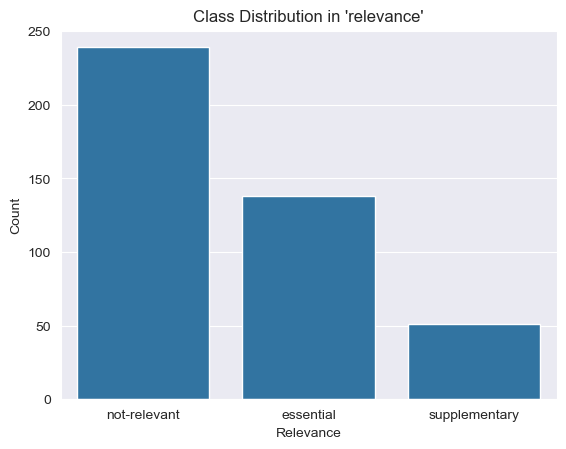

In [61]:
sns.countplot(x="relevance", data=cleaned_data)
plt.title("Class Distribution in 'relevance'")
plt.xlabel("Relevance")
plt.ylabel("Count")
plt.show()

# Transform to right format 

In [62]:
# Group by case_id and build sentence list + label list
def aggregate_case(group):
    sentences = group["sentence_text"].tolist()
    labels = [1 if rel in ["essential", "relevant"] else 0 for rel in group["relevance"]]
    return pd.Series({
        "patient_question": group["patient_question"].iloc[0],
        "clinician_question": group["clinician_question"].iloc[0],
        "note_excerpt": group["note_excerpt"].iloc[0],
        "sentences": sentences,
        "sentence_text": group["sentence_text"].iloc[0],
        "labels": labels
    })

In [63]:
data_agg = (
    cleaned_data[["case_id", "patient_question", "clinician_question", "note_excerpt", "sentence_text", "relevance"]]
    .groupby("case_id")
    .apply(aggregate_case)
    .reset_index()
)

/var/folders/m4/prj94mxs4pn6lk9nc4z7vrc80000gn/T/ipykernel_28459/3505924840.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_data[["case_id", "patient_question", "clinician_question", "note_excerpt", "sentence_text", "relevance"]]


**Quick sanity check**

In [64]:
data_agg.head()

,case_id,patient_question,clinician_question,note_excerpt,sentences,sentence_text,labels
0,1,My question is if the sludge was there does no...,Why was ERCP recommended to him over continuin...,Brief Hospital Course: During the ERCP a pancr...,"[Brief Hospital Course:, During the ERCP a pan...",Brief Hospital Course:,"[0, 1, 0, 0, 0, 1, 1, 1, 0]"
1,2,dad given multiple shots of lasciks after he w...,Why was he given lasix and his oxygen flow rat...,Brief Hospital Course: Acute diastolic heart f...,"[Brief Hospital Course:, Acute diastolic heart...",Brief Hospital Course:,"[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]"
2,3,he is continously irritated and has headache w...,What is the expected course of recovery for him?,Discharge Instructions: You were admitted to t...,[Discharge Instructions: You were admitted to ...,Discharge Instructions: You were admitted to t...,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"
3,4,My doctor performed a cardiac catherization.,Why was cardiac catheterization recommended to...,History of Present Illness: On the cardiology ...,"[History of Present Illness:, On the cardiolog...",History of Present Illness:,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"I overdosed October 4th on trihexyphenidyl, th...",Is the pain connected to the overdose or somet...,"Brief Hospital Course: # Bipolar d/o, PTSD, sc...","[Brief Hospital Course:, # Bipolar d/o, PTSD, ...",Brief Hospital Course:,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."


**Save only if needed**

In [65]:
'''
data_agg.to_csv(output_dir / "medical_data.csv", index=False)
print("Cleaned dataset saved successfully!")
''';

# In-Depth Look at the Questions

In [34]:
questions = data_agg[["patient_question", "clinician_question"]].drop_duplicates()

In [45]:
for _, row in data_agg.iterrows():
    print(f"PQ: {row['patient_question']}")
    print(f"CQ: {row['clinician_question']}")
    print("\nNote Excerpt:")
    for i, tupel in enumerate(zip(row["sentences"], row["labels"])):
        print(f"{i+1}({tupel[1]}): {tupel[0]}")
    print()
    print("--------------------------------------------------------")
    print()

PQ: My question is if the sludge was there does not the medication help in flushing it out? Whether ERCP was the only cure?
CQ: Why was ERCP recommended to him over continuing a medication-based treatment?

Note Excerpt:
1(0): Brief Hospital Course:
2(1): During the ERCP a pancreatic stent was required to facilitate access to the biliary system (removed at the end of the procedure), and a common bile duct stent was placed to allow drainage of the biliary obstruction caused by stones and sludge.
3(0): However, due to the patient's elevated INR, no sphincterotomy or stone removal was performed.
4(0): Frank pus was noted to be draining from the common bile duct, and post-ERCP it was recommended that the patient remain on IV Zosyn for at least a week.
5(0): The Vancomycin was discontinued.
6(1): On hospital day 4 (post-procedure day 3) the patient returned to ERCP for re-evaluation of her biliary stent as her LFTs and bilirubin continued an upward trend.
7(1): On ERCP the previous biliary 

In [72]:
row1 = data_agg.iloc[1]

In [73]:
row1.sentences

['Brief Hospital Course:',
 'Acute diastolic heart failure: Pt developed signs and symptoms of volume overload on [**2201-3-8**] with shortness of breath, increased oxygen requirement and lower extremity edema.',
 'Echo showed preserved EF, no WMA and worsening AI.',
 'CHF most likely secondary to worsening valvular disease.',
 'He was diuresed with lasix IV, intermittently on lasix gtt then transitioned to PO torsemide with improvement in symptoms, although remained on a small amount of supplemental oxygen for comfort.',
 "Respiratory failure: The patient was intubated for lethargy and acidosis initially and was given 8 L on his presentation to help maintain his BP's.",
 'This undoubtedly contributed to his continued hypoxemic respiratory failure.',
 'He was advanced to pressure support with stable ventilation and oxygenation.',
 'On transfer to the CCU patient was still intubated but off pressors.',
 'Patient was extubated successfully.',
 'He was reintubated [**2201-3-1**] transient